In [2]:
!pip install qulacs
!pip install qulacsvis
!pip install matplotlib
!pip install numpy
!pip install scipy
from utility import *

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState, QuantumCircuit, Observable, DensityMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacsvis import circuit_drawer
from qulacs.gate import RandomUnitary
from qulacs.state import inner_product
from qulacs.gate import to_matrix_gate
import scipy.optimize

from qulacs.gate import Identity, X,Y,Z
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag
from qulacs.gate import T,Tdag
from qulacs.gate import RX,RY,RZ
from qulacs.gate import CNOT, CZ, SWAP
from qulacs.gate import DepolarizingNoise, DephasingNoise, AmplitudeDampingNoise, TwoQubitDepolarizingNoise

# 受講証明用課題④

ハミルトニアン
$$H=\sum_{i=0}^3J_i\left(X_iX_{i+1}+Y_iY_{i+1}+Z_iZ_{i+1}\right)$$
とする。

## ハミルトニアンをオブザーバブルとして準備する。

In [6]:
nqubits = 4
hamiltonian = Observable(nqubits)
np.random.seed(1)
J_list = 2*np.random.rand(nqubits)-1
for i in range(nqubits):
    hamiltonian.add_operator(J_list[i], f"X {i} X {(i+1)%nqubits}")
    hamiltonian.add_operator(J_list[i], f"Y {i} Y {(i+1)%nqubits}")
    hamiltonian.add_operator(J_list[i], f"Z {i} Z {(i+1)%nqubits}")

## 初期状態を準備する。(Amplitude damping)

CAUTION: The 1-th Gate you added is skipped.                    This gate does not have "target_qubit_list".
CAUTION: The 3-th Gate you added is skipped.                    This gate does not have "target_qubit_list".
CAUTION: The 5-th Gate you added is skipped.                    This gate does not have "target_qubit_list".
CAUTION: The 7-th Gate you added is skipped.                    This gate does not have "target_qubit_list".
CAUTION: The 9-th Gate you added is skipped.                    This gate does not have "target_qubit_list".
CAUTION: The 11-th Gate you added is skipped.                    This gate does not have "target_qubit_list".
CAUTION: The 13-th Gate you added is skipped.                    This gate does not have "target_qubit_list".
CAUTION: The 15-th Gate you added is skipped.                    This gate does not have "target_qubit_list".
CAUTION: The 17-th Gate you added is skipped.                    This gate does not have "target_qubit_list".
CAUTION: The 19

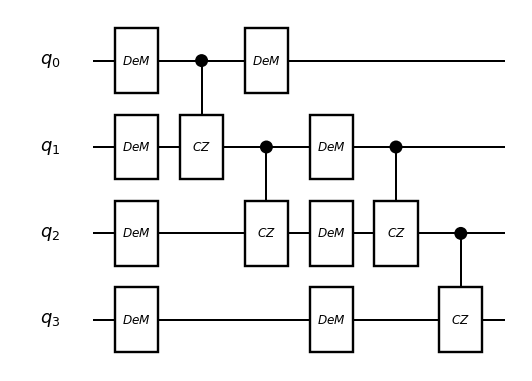

In [7]:
state = DensityMatrix(nqubits)
circuit = QuantumCircuit(nqubits)
depth = 2
np.random.seed(2)
error_rate = 0.9
for d in range(depth):
    for i in range(nqubits):
        circuit.add_U3_gate(i, *(2*np.pi*np.random.rand(3)))
        circuit.add_gate(AmplitudeDampingNoise(i,error_rate))
    for i in range(nqubits//2):
        circuit.add_CZ_gate((i+d%2)%nqubits, (i+1+d%2)%nqubits)
        circuit.add_gate(AmplitudeDampingNoise(i,error_rate))
circuit.update_quantum_state(state)

circuit_drawer(circuit, "mpl")

## 物理量XX,YY,ZZをサンプルするための関数を定義する。

In [24]:
"""
    Sample Observable ZZ.
"""
def sample_ZZ(nqubits,nshots,J_list,state):
    samples = state.sampling(nshots)
    estimated_ZZ = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
            estimated_ZZ += J*(-1)**bitcount/nshots
            
    return estimated_ZZ

In [13]:
"""
    Sample Observable XX.
"""
def sample_XX(nqubits,nshots,J_list,state):
    for i in range(nqubits):
        H(i).update_quantum_state(state)
        
    samples = state.sampling(nshots)
    estimated_XX = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
            estimated_XX += J*(-1)**bitcount/nshots
    
    for i in range(nqubits):
        H(i).update_quantum_state(state)
        
    return estimated_XX

In [16]:
"""
    Sample Observable YY.
"""
def sample_YY(nqubits,nshots,J_list,state):
    for i in range(nqubits):
        Sdag(i).update_quantum_state(state)
        H(i).update_quantum_state(state)
        
    samples = state.sampling(nshots)
    estimated_YY = 0
    mask_list = [0b0011, 0b0110, 0b1100, 0b1001]
    for s in samples:
        for J, mask in zip(J_list, mask_list):
            bitcount = bin(s & mask).count("1")
            estimated_YY += J*(-1)**bitcount/nshots
    
    for i in range(nqubits):
        H(i).update_quantum_state(state)
        S(i).update_quantum_state(state)
        
    return estimated_YY

## サンプルから得られる期待値と厳密な期待値を比べる。

error_rate= 0.9  nshots= 1000  :  -1.0798724879909378
error_rate= 0  nshots= infinity  :  -1.0798098117941257


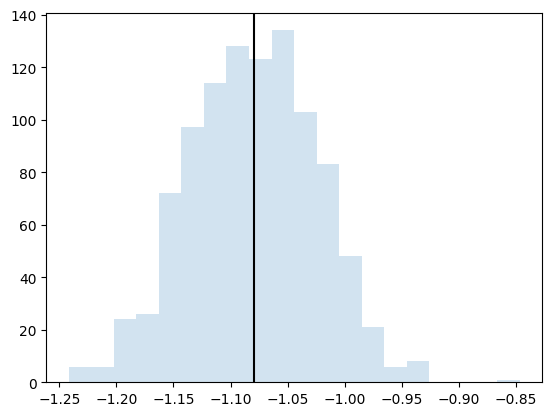

In [17]:
ntest = 1000
nshots = 1000
result_list = np.zeros(ntest)
for i in range(ntest):
    result_list[i] = sample_ZZ(nqubits,nshots,J_list,state) + sample_XX(nqubits,nshots,J_list,state) + sample_YY(nqubits,nshots,J_list,state)
plt.hist(result_list, alpha=0.2, bins=20)
print("error_rate=",error_rate," nshots=",nshots," : ",np.mean(result_list))
print("error_rate=",0," nshots= infinity"," : ",hamiltonian.get_expectation_value(state))
plt.axvline(hamiltonian.get_expectation_value(state), color="black")
plt.show()

## エラー率に対してサンプルによって得られる期待値の変化を見る。

Amplitude Damping NoiseとDephasing Noizeを用いてそれぞれハミルトニアンの期待値をサンプリングから求めた。

グラフのエラーバーには、ハミルトニアンの期待値をntest回求めたときの標準偏差を用いた。

### Amplitude Damping Noiseを用いた場合

In [51]:
ntest = 100
nshots = 1000
res_sampling = np.array([])
res_sampling_std = np.array([])
res_exact = np.array([])
list_error_rate = np.array([])
for e in range(0,100,2):
    # create initial state
    state = DensityMatrix(nqubits)
    circuit = QuantumCircuit(nqubits)
    depth = 2
    error_rate = e/100
    list_error_rate = np.append(list_error_rate,(error_rate))
    np.random.seed(12)
    for d in range(depth):
        for i in range(nqubits):
            circuit.add_U3_gate(i, *(2*np.pi*np.random.rand(3)))
            circuit.add_gate(AmplitudeDampingNoise(i,error_rate))
        for i in range(nqubits//2):
            circuit.add_CZ_gate((i+d%2)%nqubits, (i+1+d%2)%nqubits)
            circuit.add_gate(AmplitudeDampingNoise(i,error_rate))
    circuit.update_quantum_state(state)
    
    # sample observables
    result_list = np.zeros(ntest)
    for i in range(ntest):
        result_list[i] = sample_ZZ(nqubits,nshots,J_list,state) + sample_XX(nqubits,nshots,J_list,state) + sample_YY(nqubits,nshots,J_list,state)
    res_sampling = np.append(res_sampling,np.mean(result_list))
    res_sampling_std = np.append(res_sampling_std,np.std(res_sampling))
    res_exact = np.append(res_exact,res_sampling[0])

relative_error = abs((res_sampling - res_exact)/res_exact)

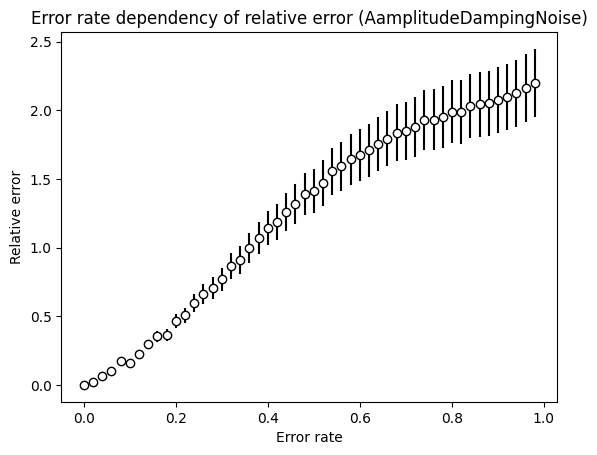

In [52]:
plt.errorbar(list_error_rate,relative_error,yerr=res_sampling_std,ecolor='black',fmt='o',markeredgecolor = "black", color='w')
plt.title("Error rate dependency of relative error (AamplitudeDampingNoise)")
plt.xlabel("Error rate")
plt.ylabel("Relative error")
plt.show()

Amplitude Damping Noiseを使った場合、エラー率が増加するにあたって線形に相対誤差が増えていき、その変化は徐々に緩やかになっていくことがわかる。さらに、各エラー率においてサンプリングによって得られる期待値のばらつきが大きくなっていることもわかる。

### Dephasing Noiseを用いた場合

In [55]:
ntest = 100
nshots = 1000
res_sampling = np.array([])
res_sampling_std = np.array([])
res_exact = np.array([])
list_error_rate = np.array([])
for e in range(0,50,1):
    # create initial state
    state = DensityMatrix(nqubits)
    circuit = QuantumCircuit(nqubits)
    depth = 2
    error_rate = e/100
    list_error_rate = np.append(list_error_rate,(error_rate))
    np.random.seed(100)
    for d in range(depth):
        for i in range(nqubits):
            circuit.add_U3_gate(i, *(2*np.pi*np.random.rand(3)))
            circuit.add_gate(DephasingNoise(i,error_rate))
        for i in range(nqubits//2):
            circuit.add_CZ_gate((i+d%2)%nqubits, (i+1+d%2)%nqubits)
            circuit.add_gate(DephasingNoise(i,error_rate))
    circuit.update_quantum_state(state)
    
    # sample observables
    result_list = np.zeros(ntest)
    for i in range(ntest):
        result_list[i] = sample_ZZ(nqubits,nshots,J_list,state) + sample_XX(nqubits,nshots,J_list,state) + sample_YY(nqubits,nshots,J_list,state)
    res_sampling = np.append(res_sampling,np.mean(result_list))
    res_sampling_std = np.append(res_sampling_std,np.std(res_sampling))
    res_exact = np.append(res_exact,res_sampling[0])

relative_error = abs((res_sampling - res_exact)/res_exact)

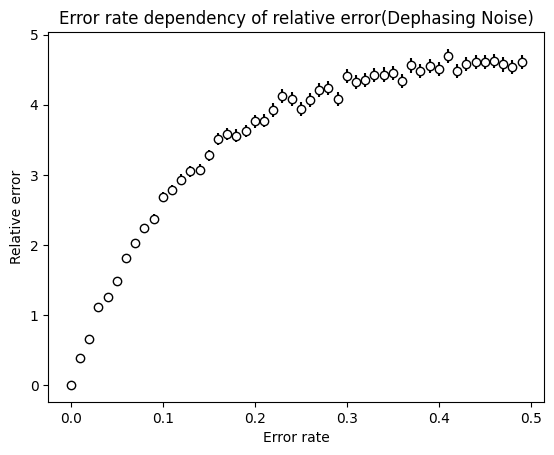

In [56]:
plt.errorbar(list_error_rate,relative_error,yerr=res_sampling_std,ecolor='black',fmt='o',markeredgecolor = "black", color='w')
plt.title("Error rate dependency of relative error(Dephasing Noise)")
plt.xlabel("Error rate")
plt.ylabel("Relative error")
plt.show()

Dephasing Noizeをを使った場合、エラー率に対して急激に相対誤差が増加し、徐々に一定値に漸近していることがわかる。また、Amplitude Damping Noiseと比べてばらつきの変化が小さいが、同様にエラー率に対して増加していることもわかる。